In [1]:
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

import joblib
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse
from darts.models import RNNModel, XGBModel, VARIMA
from darts.models.forecasting.forecasting_model import ForecastingModel

from model import config, data, evaluation, feature_engineering
from model.feature_engineering import get_covariates_time
from model.util import get_covariate_args_for_model

In [2]:
weights = {
    "biomass_mwh": 485.0,
    "hydropower_mwh": 24.0,
    "wind_offshore_mwh": 12.0,
    "wind_onshore_mwh": 11.0,
    "photovoltaic_mwh": 38.666666666666664,
    "other_renewables_mwh": 38.0,
    "nuclear_mwh": 12.0,
    "brown_coal_mwh": 820.0,
    "hard_coal_mwh": 820.0,
    "natural_gas_mwh": 490.0,
    "pumped_storage_mwh": 20.5,
    "other_conventional_mwh": 655.0,
}

In [3]:
titles = ["Biomass", "Hydropower", "Wind Offshore","Wind Onshore","Photovoltaic","Other Renewables","Nuclear","Brown Coal",
"Hard Coal", "Natural Gas","Pumped Storage","Other Conventional"]

In [4]:
weights_list = list(weights.values())

In [5]:
def co2rmse(y_true,y_pred, weight):
    diff = weight * (y_true - y_pred)
    mse = np.mean(diff**2, axis=0)
    rmse = np.sqrt(mse)
    return rmse

## LSTM Comparison

In [6]:
relative_path = os.path.join(os.getcwd(), os.pardir)

lstm_model = RNNModel.load(f"{relative_path}/model_results/lstm/model")
lstm_scaler = joblib.load(f"{relative_path}/model_results/lstm/scaler_smard")
lstm_model

C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: The loaded checkpoint was produced with Lightning v2.1.3, which is newer than your current Lightning version: v2.1.1


RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=3, dropout=0.028777667213468805, training_length=424, input_chunk_length=212, n_epochs=5, force_reset=True)

In [7]:
dataset = data.load()
weather_data = dataset.weather
smard_data = dataset.train

In [8]:
lstm_scaler = Scaler()
lstm_scaler.fit(dataset.train)

Scaler

In [9]:
prefix_series=dataset.train.concatenate(dataset.val)
full_series = prefix_series.concatenate(dataset.test)
full_series_scaled = lstm_scaler.transform(full_series)
start = prefix_series.end_time()

In [10]:
covariates_time = get_covariates_time(weather_data)
covariates = weather_data.stack(covariates_time)
_, covariate_args_inference = get_covariate_args_for_model(lstm_model, covariates)
result = lstm_model.predict(24*7, series=full_series_scaled[:start], **covariate_args_inference, verbose=False)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [11]:
covariate_args_inference

{'future_covariates': <TimeSeries (DataArray) (timestamp: 77929, component: 8, sample: 1)>
 array([[[1.6299999e+01],
         [1.0321000e+03],
         [3.9000001e+00],
         ...,
         [5.0000000e-01],
         [0.0000000e+00],
         [0.0000000e+00]],
 
        [[1.6500000e+01],
         [1.0320000e+03],
         [3.5000000e+00],
         ...,
         [5.0000000e-01],
         [4.3478262e-02],
         [0.0000000e+00]],
 
        [[1.5100000e+01],
         [1.0321000e+03],
         [3.0999999e+00],
         ...,
 ...
         ...,
         [1.6666667e-01],
         [9.5652175e-01],
         [9.0909088e-01]],
 
        [[1.0700000e+01],
         [1.0272000e+03],
         [2.2000000e+00],
         ...,
         [1.6666667e-01],
         [1.0000000e+00],
         [9.0909088e-01]],
 
        [[1.0400000e+01],
         [1.0277000e+03],
         [1.7000000e+00],
         ...,
         [3.3333334e-01],
         [0.0000000e+00],
         [9.0909088e-01]]], dtype=float32)
 Coordinate

In [12]:
forecast = lstm_scaler.inverse_transform(result) #rescaled

In [13]:
actual_data = full_series[result.start_time() : result.end_time()]

In [14]:
forecast.time_index

DatetimeIndex(['2023-03-05 01:00:00', '2023-03-05 02:00:00',
               '2023-03-05 03:00:00', '2023-03-05 04:00:00',
               '2023-03-05 05:00:00', '2023-03-05 06:00:00',
               '2023-03-05 07:00:00', '2023-03-05 08:00:00',
               '2023-03-05 09:00:00', '2023-03-05 10:00:00',
               ...
               '2023-03-11 15:00:00', '2023-03-11 16:00:00',
               '2023-03-11 17:00:00', '2023-03-11 18:00:00',
               '2023-03-11 19:00:00', '2023-03-11 20:00:00',
               '2023-03-11 21:00:00', '2023-03-11 22:00:00',
               '2023-03-11 23:00:00', '2023-03-12 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=168, freq='H')

In [15]:
actual_data.time_index

DatetimeIndex(['2023-03-05 01:00:00', '2023-03-05 02:00:00',
               '2023-03-05 03:00:00', '2023-03-05 04:00:00',
               '2023-03-05 05:00:00', '2023-03-05 06:00:00',
               '2023-03-05 07:00:00', '2023-03-05 08:00:00',
               '2023-03-05 09:00:00', '2023-03-05 10:00:00',
               ...
               '2023-03-11 15:00:00', '2023-03-11 16:00:00',
               '2023-03-11 17:00:00', '2023-03-11 18:00:00',
               '2023-03-11 19:00:00', '2023-03-11 20:00:00',
               '2023-03-11 21:00:00', '2023-03-11 22:00:00',
               '2023-03-11 23:00:00', '2023-03-12 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=168, freq='H')

In [16]:
df_actual = pd.DataFrame(actual_data.values())
df_predicted_lstm = pd.DataFrame(forecast.values())

In [17]:
df_actual

,0,1,2,3,4,5,6,7,8,9,10,11
0,4717.50,1043.25,3648.50,12439.75,0.0,194.50,2955.25,10550.00,4839.00,6158.25,120.00,1358.00
1,4700.25,1035.00,3721.25,13253.00,0.0,194.00,2958.50,10352.25,4985.50,6099.75,138.75,1335.25
2,4687.50,1053.25,3476.75,13507.00,0.0,194.00,2956.25,10282.75,4983.75,5791.00,231.00,1349.75
3,4693.25,1020.75,3578.50,13721.00,0.0,194.00,2953.25,10078.00,4813.00,5886.50,207.75,1328.25
4,4713.50,1023.25,3574.25,13702.50,0.0,193.00,2953.00,10248.50,4432.00,5931.50,213.75,1313.75
...,...,...,...,...,...,...,...,...,...,...,...,...
163,4854.00,1242.75,1878.75,13650.75,0.0,193.00,2919.75,9400.25,6465.50,6227.50,5663.75,1466.25
164,4782.75,1187.50,1203.50,13355.00,0.0,194.00,2920.25,9425.50,6399.00,6199.25,3134.75,1470.75
165,4686.00,1263.75,1062.50,12840.50,0.0,194.50,2922.75,9276.00,6066.75,6004.00,2527.00,1486.50
166,4630.50,1227.00,972.25,12807.25,0.0,194.75,2922.00,8923.00,5688.50,5923.25,733.75,1490.00


## VARIMA

In [18]:
varima_model = VARIMA.load(f"{relative_path}/model_results/varima/model")

In [19]:
_, covariate_args_inference_varima = get_covariate_args_for_model(varima_model, covariates)
varima_predictions = varima_model.predict(24*7, series=full_series[:start], **covariate_args_inference_varima, verbose=False)

C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tiger\miniforge3\envs\aip-porsche\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimati

In [20]:
varima_predictions.time_index

DatetimeIndex(['2023-03-05 01:00:00', '2023-03-05 02:00:00',
               '2023-03-05 03:00:00', '2023-03-05 04:00:00',
               '2023-03-05 05:00:00', '2023-03-05 06:00:00',
               '2023-03-05 07:00:00', '2023-03-05 08:00:00',
               '2023-03-05 09:00:00', '2023-03-05 10:00:00',
               ...
               '2023-03-11 15:00:00', '2023-03-11 16:00:00',
               '2023-03-11 17:00:00', '2023-03-11 18:00:00',
               '2023-03-11 19:00:00', '2023-03-11 20:00:00',
               '2023-03-11 21:00:00', '2023-03-11 22:00:00',
               '2023-03-11 23:00:00', '2023-03-12 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=168, freq='H')

In [21]:
df_varima_predictions = pd.DataFrame(varima_predictions.values())
df_varima_predictions

,0,1,2,3,4,5,6,7,8,9,10,11
0,4667.200175,1039.004024,3324.363055,13493.442477,582.132751,194.073600,2950.533907,10474.264886,5054.175451,6046.189516,353.877755,1376.296492
1,4653.386839,1038.493213,3276.476829,13771.738496,1142.479825,193.604393,2950.557134,10286.569369,5192.592843,6028.372331,81.648855,1377.326120
2,4651.936450,1041.021771,3255.503077,14116.955945,1453.282018,192.862831,2948.816348,10186.054188,5334.394398,6039.841090,-60.421718,1378.111312
3,4660.277715,1044.889303,3257.691086,14551.093123,1490.638184,192.036446,2945.962769,10121.516145,5474.163332,6072.210203,-58.341976,1378.238595
4,4675.439979,1049.433676,3267.841230,15004.863741,1352.810588,191.201102,2942.605799,10078.196075,5610.492842,6118.958070,50.697133,1378.156783
...,...,...,...,...,...,...,...,...,...,...,...,...
163,4857.290953,1228.411884,3471.847709,19333.657350,113.692996,165.570221,2636.794200,10772.112202,8972.419693,6761.351477,1469.355137,1346.823652
164,4877.444837,1229.886330,3457.986721,19192.539915,-1107.206352,165.929893,2633.508152,10889.297524,9096.201750,6862.684068,1662.861343,1343.932080
165,4894.537598,1231.459202,3430.011997,18916.955591,-1287.747810,166.378295,2633.518786,10988.715465,9189.047767,6960.695305,1911.366669,1348.710688
166,4902.669547,1232.808153,3374.545358,18346.602593,-928.666275,166.798210,2633.716331,11126.966941,9278.028046,7032.702594,2110.656871,1354.739961


## XGBoost Comparison

In [22]:
xgb_model = XGBModel.load(f"{relative_path}/model_results/xgb_featureeng_refit/model")
xgb_scaler = joblib.load(f"{relative_path}/model_results/xgb_featureeng/scaler_smard")
xgb_model

XGBModel(lags=[-1, -2, -3, -4, -8, -16, -24, -48, -168, -336, -672, -1344], lags_past_covariates=[-1, -2, -3, -4, -8, -16, -24, -48, -168, -336, -672, -1344], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, max_depth=8, n_estimators=682, verbosity=0)

In [23]:
dataset = data.load()
weather_data = dataset.weather
smard_data = dataset.train

In [24]:
xgb_scaler = Scaler()
xgb_scaler.fit(dataset.train)

Scaler

In [25]:
prefix_series=dataset.train.concatenate(dataset.val)
full_series = prefix_series.concatenate(dataset.test)
full_series_scaled = xgb_scaler.transform(full_series)
start = prefix_series.end_time()

In [26]:
#only for XGBoost

covariates_time = get_covariates_time(dataset.weather)

covariates = dataset.weather.stack(covariates_time)

covariates = feature_engineering.add_rolling_mean(covariates, 1)
covariates = feature_engineering.add_rolling_mean(covariates, 24)
covariates = feature_engineering.add_rolling_mean(covariates, 24 * 7)
covariates = feature_engineering.add_kinetic_wind_energy_simplified(covariates)

In [27]:
covariates.time_index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2023-11-21 15:00:00', '2023-11-21 16:00:00',
               '2023-11-21 17:00:00', '2023-11-21 18:00:00',
               '2023-11-21 19:00:00', '2023-11-21 20:00:00',
               '2023-11-21 21:00:00', '2023-11-21 22:00:00',
               '2023-11-21 23:00:00', '2023-11-22 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=77929, freq='H')

In [28]:
covariates

<TimeSeries (DataArray) (timestamp: 77929, component: 65, sample: 1)>
array([[[1.62999992e+01],
        [1.03209998e+03],
        [3.90000010e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [2.74218625e+05]],

       [[1.65000000e+01],
        [1.03200000e+03],
        [3.50000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [2.80962000e+05]],

       [[1.51000004e+01],
        [1.03209998e+03],
        [3.09999990e+00],
        ...,
...
        ...,
        [5.00000000e-01],
        [9.09090877e-01],
        [1.02669992e+05]],

       [[1.06999998e+01],
        [1.02719995e+03],
        [2.20000005e+00],
        ...,
        [5.00000000e-01],
        [9.09090877e-01],
        [1.17604117e+05]],

       [[1.03999996e+01],
        [1.02769995e+03],
        [1.70000005e+00],
        ...,
        [5.00000000e-01],
        [9.09090877e-01],
        [1.11156016e+05]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2015-01-01 ... 2023-11-22
  * component  (component) object 'wspd' 'pres' ... 'kinetic_wind_energy'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [29]:
xgb_model.supports_future_covariates

False

In [30]:
pip install xgboost==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [31]:
#covariates_time = get_covariates_time(weather_data)
#covariates = weather_data.stack(covariates_time)
_, covariate_args_inference = get_covariate_args_for_model(xgb_model, covariates)
result = xgb_model.predict(24*7, series=full_series_scaled[:start], **covariate_args_inference, verbose=False)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [32]:
covariate_args_inference

{'past_covariates': <TimeSeries (DataArray) (timestamp: 77929, component: 65, sample: 1)>
 array([[[1.62999992e+01],
         [1.03209998e+03],
         [3.90000010e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [2.74218625e+05]],
 
        [[1.65000000e+01],
         [1.03200000e+03],
         [3.50000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [2.80962000e+05]],
 
        [[1.51000004e+01],
         [1.03209998e+03],
         [3.09999990e+00],
         ...,
 ...
         ...,
         [5.00000000e-01],
         [9.09090877e-01],
         [1.02669992e+05]],
 
        [[1.06999998e+01],
         [1.02719995e+03],
         [2.20000005e+00],
         ...,
         [5.00000000e-01],
         [9.09090877e-01],
         [1.17604117e+05]],
 
        [[1.03999996e+01],
         [1.02769995e+03],
         [1.70000005e+00],
         ...,
         [5.00000000e-01],
         [9.09090877e-01],
         [1.11156016e+05]]

In [33]:
forecast = xgb_scaler.inverse_transform(result) #rescaled

In [34]:
actual_data = full_series[result.start_time() : result.end_time()]

In [35]:
df_actual = pd.DataFrame(actual_data.values())
df_predicted = pd.DataFrame(forecast.values())

In [36]:
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 17))
# fig.suptitle('XGBoost Comparison', fontsize=18, y=0.92)  # Adjusting the vertical position of the main title
# 
# for i, column in enumerate(df_actual.columns):
#     row_index = i // 3
#     col_index = i % 3
#     
#     # Calculate RMSE
#     rmse = np.sqrt(((df_actual[column] - df_predicted[column]) ** 2).mean())
#     co2_rmse = co2rmse(df_actual[column], df_predicted[column], weight=weights_list[i])
# 
#     axes[row_index, col_index].plot(df_actual.index, df_actual[column], label='Actual')
#     axes[row_index, col_index].plot(df_predicted.index, df_predicted[column], label='predicted')
#     axes[row_index, col_index].set_title(f'{smard_data.columns[i][:-4]}\n\n\n', fontsize=13)#\nRMSE: {rmse:.2f}\nCO2-RMSE: {co2_rmse:.2f}')
#     axes[row_index, col_index].set_xlabel('Hours')
#     axes[row_index, col_index].set_ylabel('MWh')
#     axes[row_index, col_index].legend()
# 
#     # Rotate x-axis tick labels and set ticks every 24 data points
#     #axes[row_index, col_index].tick_params(axis='x', rotation=45)
#     axes[row_index, col_index].set_xticks(df_actual.index[::24])
# 
#     subtitle_text = f'weight: {weights_list[i]} \n XGB: rmse {rmse:.2f}, co2-rmse {co2_rmse:.2f} '
#     axes[row_index, col_index].text(0.5, 1.17, subtitle_text, ha='center', va='center', transform=axes[row_index, col_index].transAxes)
# 
# plt.tight_layout(rect=[0, 0, 1, 0.9])  # Increasing the gap between title and subplots
# plt.show()

## Three models in Comparison

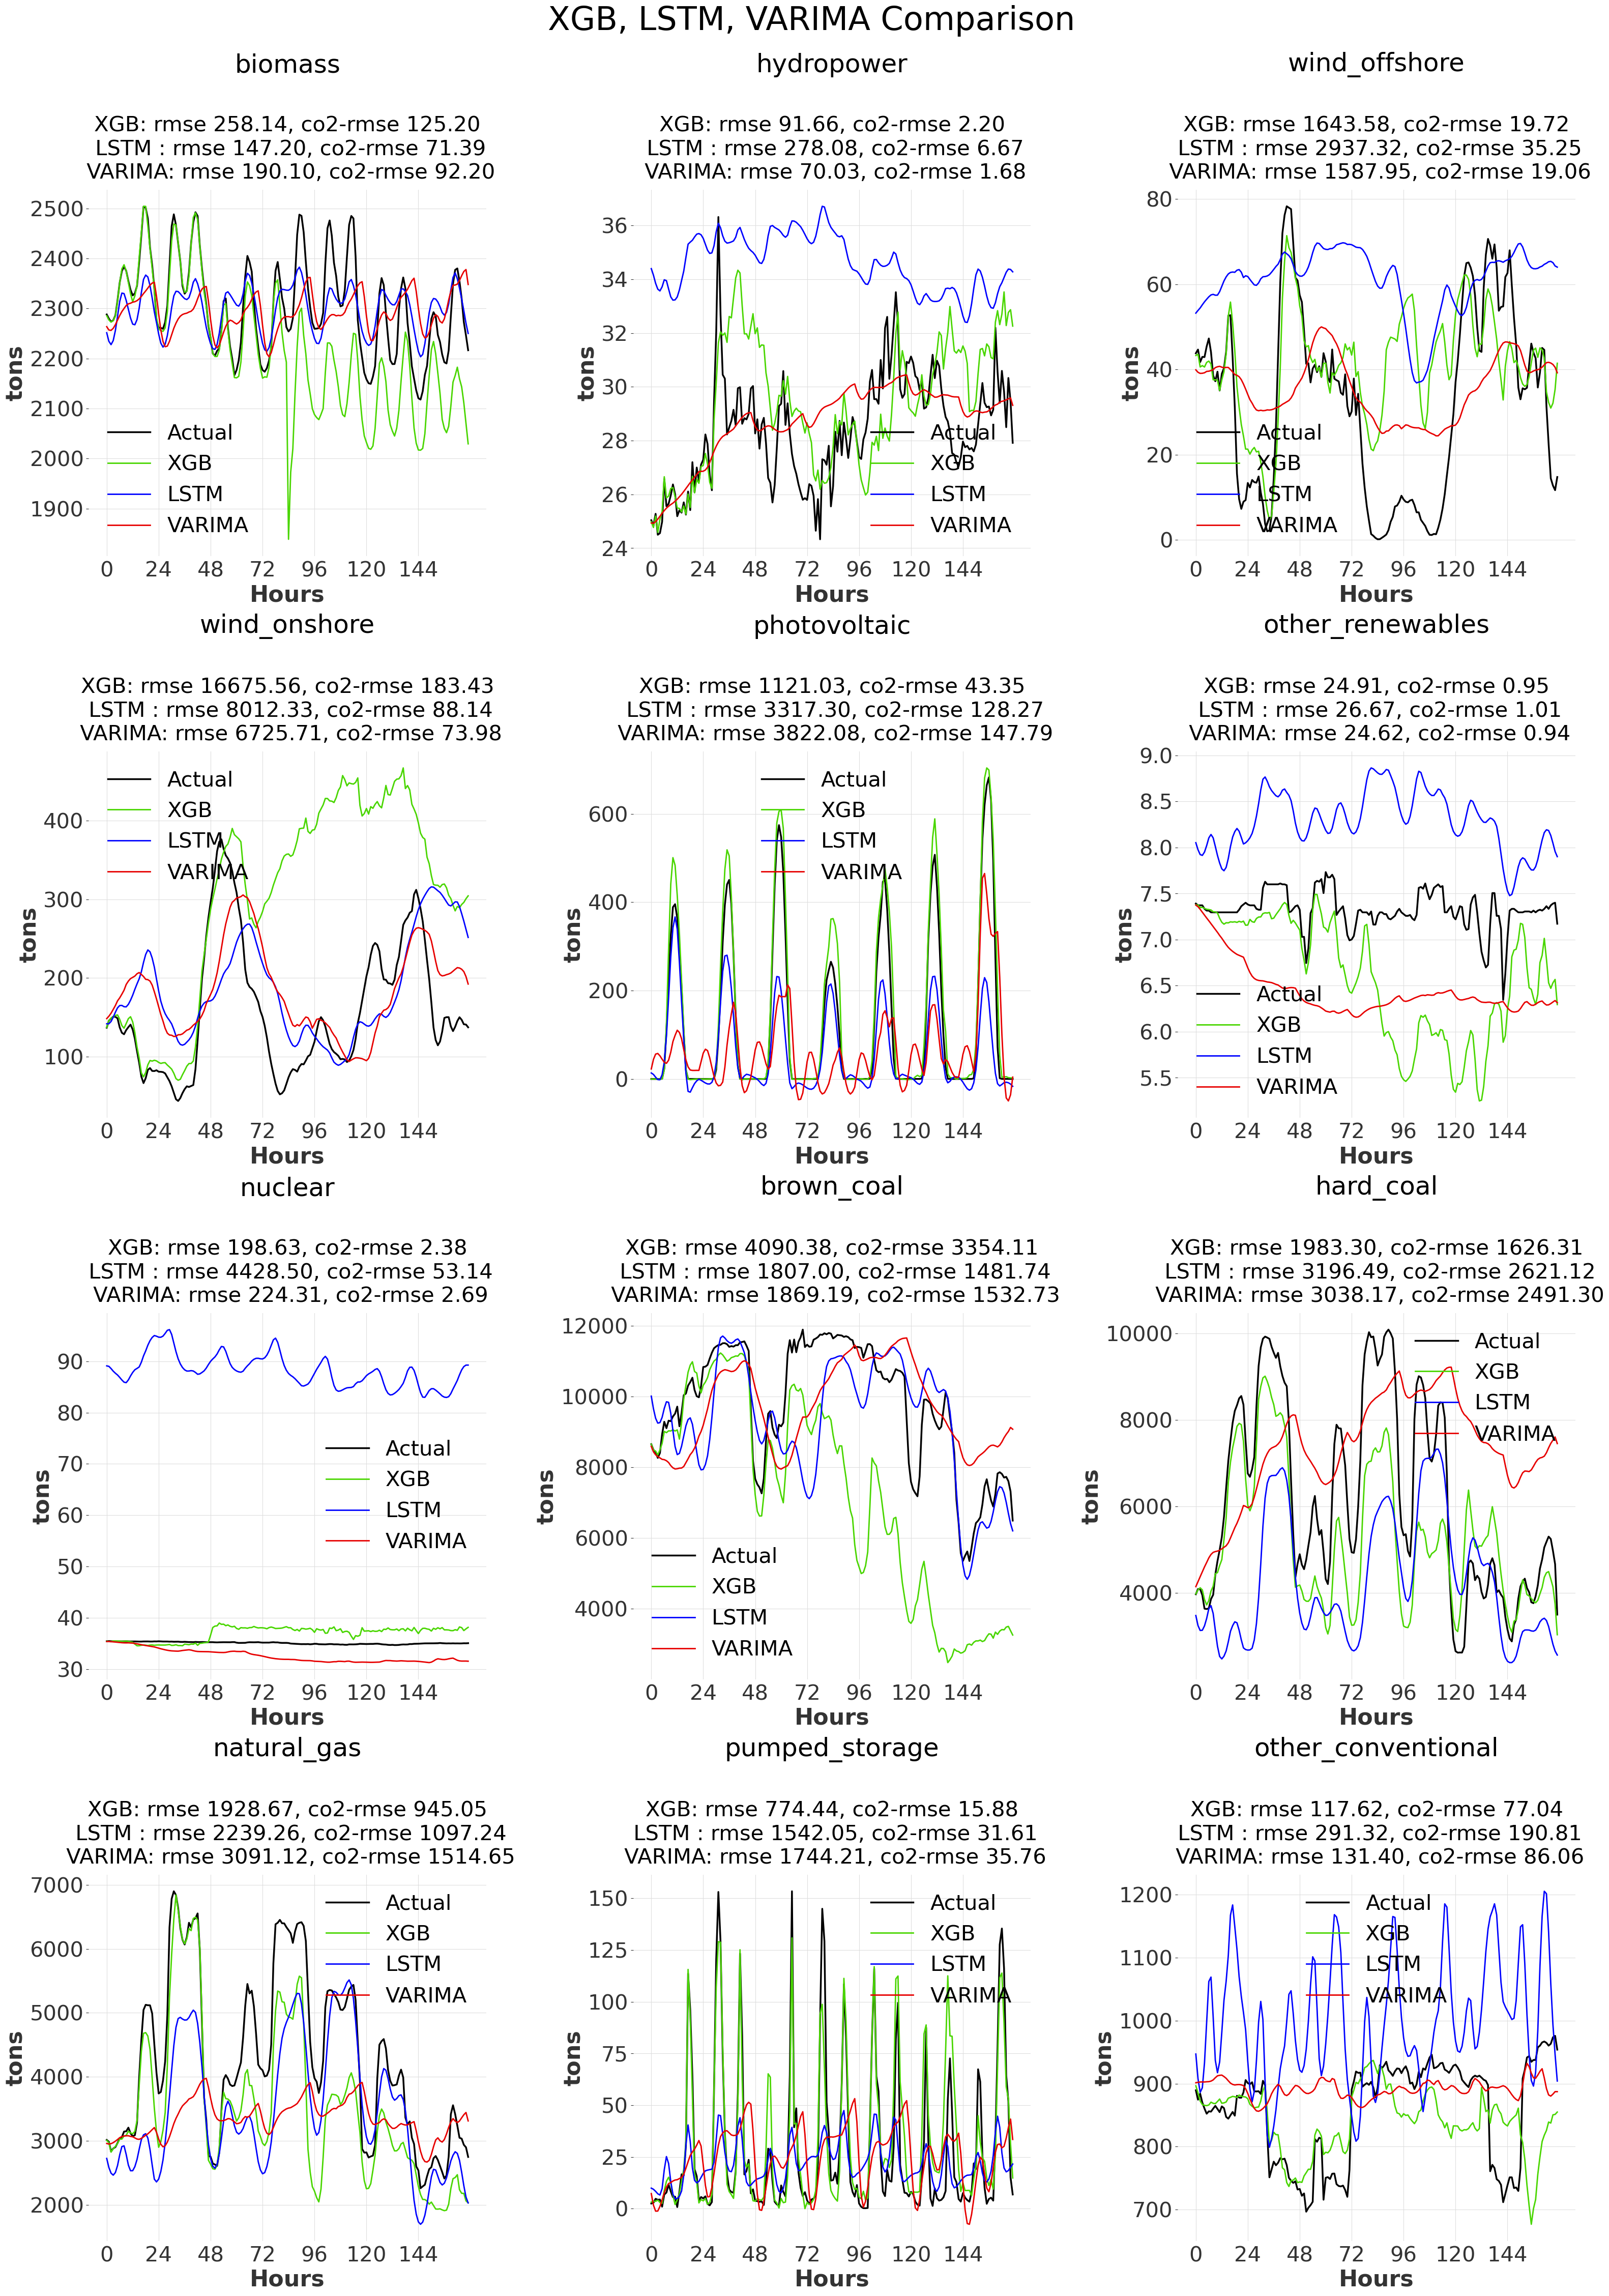

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample DataFrames
# Assuming you have df_actual and df_predicted defined

# List of titles

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(32, 46))
fig.suptitle('XGB, LSTM, VARIMA Comparison', fontsize=46, y=0.98)  # Adjusting the vertical position of the main title

for i, column in enumerate(df_actual.columns):
    row_index = i // 3
    col_index = i % 3
    
    # Calculate RMSE
    rmse = np.sqrt(((df_actual[column] - df_predicted[column]) ** 2).mean())
    co2_rmse = co2rmse(df_actual[column], df_predicted[column], weight=weights_list[i]) / 1000.
    rmse_lstm = np.sqrt(((df_actual[column] - df_predicted_lstm[column]) ** 2).mean())
    co2_rmse_lstm = co2rmse(df_actual[column], df_predicted_lstm[column], weight=weights_list[i]) / 1000.
    rmse_varima = np.sqrt(((df_actual[column] - df_varima_predictions[column]) ** 2).mean())
    co2_rmse_varima = co2rmse(df_actual[column], df_varima_predictions[column], weight=weights_list[i]) / 1000.

    # axes[row_index, col_index].plot(df_actual.index, df_actual[column], label='Actual')
    # axes[row_index, col_index].plot(df_predicted.index, df_predicted[column], label='XGB')
    # axes[row_index, col_index].plot(df_predicted_lstm.index, df_predicted_lstm[column], label='LSTM')
    # axes[row_index, col_index].plot(df_varima_predictions.index, df_varima_predictions[column], label='VARIMA')
    axes[row_index, col_index].plot(df_actual.index, df_actual[column].apply(lambda x: (x * weights_list[i]) / 1000.), label='Actual', linewidth=2.5, color='#000000')
    axes[row_index, col_index].plot(df_predicted.index, df_predicted[column].apply(lambda x: (x * weights_list[i]) / 1000.), label='XGB', linewidth=2, color='#49d600')
    axes[row_index, col_index].plot(df_predicted_lstm.index, df_predicted_lstm[column].apply(lambda x: (x * weights_list[i]) / 1000.), label='LSTM', linewidth=2, color='#0002ff')
    axes[row_index, col_index].plot(df_varima_predictions.index, df_varima_predictions[column].apply(lambda x: (x * weights_list[i]) / 1000.), label='VARIMA', linewidth=2, color='#e70000')
    axes[row_index, col_index].set_title(f'{smard_data.columns[i][:-4]}\n\n\n\n', fontsize=36)#\nRMSE: {rmse:.2f}\nCO2-RMSE: {co2_rmse:.2f}')
    axes[row_index, col_index].set_xlabel('Hours', fontsize=32)
    axes[row_index, col_index].set_ylabel('tons', fontsize=32)
    axes[row_index, col_index].legend(fontsize=30)

    # Rotate x-axis tick labels and set ticks every 24 data points
    #axes[row_index, col_index].tick_params(axis='x', rotation=45)
    axes[row_index, col_index].set_xticks(df_actual.index[::24])
    # axes[row_index, col_index].set_xticklabels(df_actual.index[::24], fontsize=18)

    # axes[row_index, col_index].set_ylim(0, 12000)

    subtitle_text = (f'XGB: rmse {rmse:.2f}, co2-rmse {co2_rmse:.2f}\n LSTM : rmse {rmse_lstm:.2f}, co2-rmse {co2_rmse_lstm:.2f}\n '
                     f'VARIMA: rmse {rmse_varima:.2f}, co2-rmse {co2_rmse_varima:.2f}')
    axes[row_index, col_index].text(0.5, 1.11, subtitle_text, ha='center', va='center', transform=axes[row_index, col_index].transAxes, fontsize=30)

    axes[row_index, col_index].tick_params(axis='both', which='major', labelsize=30)
    
    # extent = axes[row_index, col_index].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # 
    # fig.savefig(f'{smard_data.columns[i][:-4]}_CO2.png', bbox_inches = extent.expanded(1.4, 1.5))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Increasing the gap between title and subplots
plt.savefig('comparison_tons.svg')
plt.show()